In [41]:
from __future__ import absolute_import
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

def f(val):
    return "%.2f" % (val)

def describe(data):
    columns = [ 'type', 'Nas', '0s', 'min', 'max', 'mean', '.25', '.50', '.75', '.95', 'uniq' ]
    desc    = pd.DataFrame(index=data.columns, columns=columns)
    
    for c in data.columns:
        if(data[c].dtype == 'object'):
            _0s  = (data[c] == '').sum()
            vals = data[c].value_counts()
            min  = "%s: %d" % ( vals.index[-1], vals.values[-1] )
            max  = "%s: %d" % ( vals.index[ 0], vals.values[ 0] )
            uniq = vals.shape[0]
        else:
            _0s  = (data[c] == 0).sum()
            vals = data[c]
            min  = vals.min()
            max  = vals.max()
            uniq = ''
        
        _25, _50, _75, _95 = vals.dropna().quantile([ .25, .50, .75, .95 ]).apply(f)
        mean, std, cnt, na = vals.mean(), vals.std(), data[c].shape[0] * 1.0,  data[c].isnull().sum()
        desc.loc[c]        = ( data[c].dtype, f(na / cnt), f(_0s / cnt), min, max, f(mean), _25, _50, _75, _95, uniq )
    
    return desc.sort_values(by='type')


In [9]:
df = pd.read_csv('conversion_data.csv')

In [10]:
describe(df)

,type,Nas,0s,min,max,mean,.25,.50,.75,.95,uniq
age,int64,0.00,0.00,17,123,30.57,24.00,30.00,36.00,45.00,
new_user,int64,0.00,0.31,0,1,0.69,0.00,1.00,1.00,1.00,
total_pages_visited,int64,0.00,0.00,1,29,4.87,2.00,4.00,7.00,11.00,
converted,int64,0.00,0.97,0,1,0.03,0.00,0.00,0.00,0.00,
country,object,0.00,0.00,Germany: 13056,US: 178092,79050.00,39601.50,62526.00,101974.50,162868.50,4
source,object,0.00,0.00,Direct: 72420,Seo: 155040,105400.00,80580.00,88740.00,121890.00,148410.00,3


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1139a1590>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1098fc990>]], dtype=object)

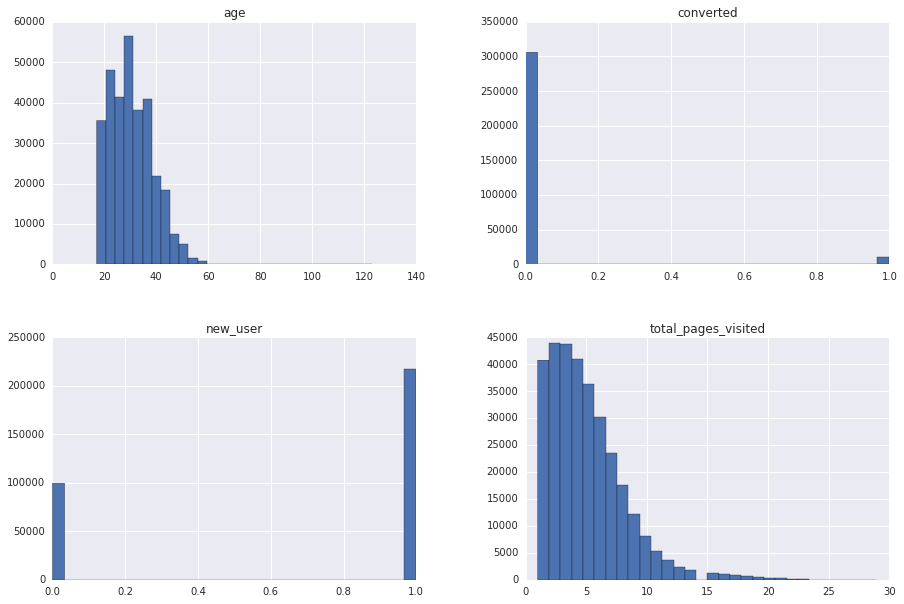

In [46]:
df.hist(bins=30, figsize=(15,10))

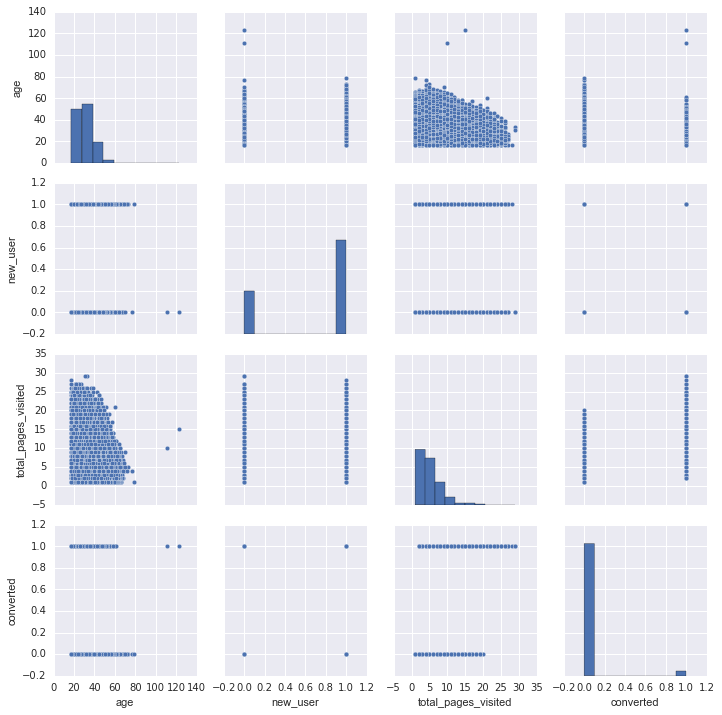

In [44]:
sns.pairplot(df.select_dtypes(['int']))

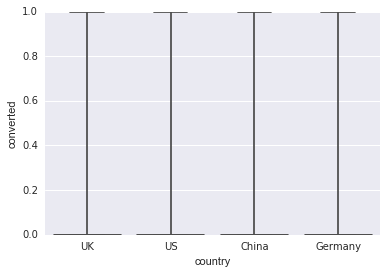

In [56]:
sns.boxplot(data=df, x='country', y='converted')

In [ ]:
from sklearn.linear_model import *
from sklearn.ensemble import *
from sklearn.model_selection import *
from sklearn.preprocessing import *

def evaluate(model, **kwargs):
    scrs = cross_val_score(model, **kwargs)
    print model.__class__.__name__, scrs.mean(), scrs.std() 

y = df.converted
x = df[df.columns[~df.columns.isin(['converted'])]]

x['country'] = LabelEncoder().fit_transform(x['country'])
x['source'] = LabelEncoder().fit_transform(x['source'])


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [69]:

rf = RandomForestClassifier(min_weight_fraction_leaf=0.01, n_estimators=100)
print evaluate(rf, X=x, y=y, scoring='roc_auc', cv=5)

RandomForestClassifier 0.983293605024 0.00070543155253
None


In [105]:
rf.fit(x, y)
print "\n".join(map(str, zip(x.columns, rf.feature_importances_)))

('country', 0.011514597682707531)
('age', 0.011700804686163862)
('new_user', 0.035343142370982961)
('source', 0.00012870901136849189)
('total_pages_visited', 0.94131274624877692)


In [106]:
x_new = x[[ c for c in x.columns if c != 'total_pages_visited' ]]
print evaluate(rf, X=x, y=y, scoring='roc_auc', cv=5)
rf.fit(x_new, y)
print "\n".join(map(str, zip(x_new.columns, rf.feature_importances_)))

RandomForestClassifier 0.983487224465 0.000731533100874
None
('country', 0.26589157075300934)
('age', 0.24876043390766595)
('new_user', 0.48002599431977511)
('source', 0.0053220010195495814)


In [82]:
sgd = SGDClassifier(loss='log', penalty='elasticnet', alpha=0.0001, l1_ratio=0.1)
print evaluate(sgd, X=x, y=y, scoring='roc_auc', cv=5)

SGDClassifier 0.980359059817 0.00092207794912
None


In [104]:
sgd.fit(x,y)
print "\n".join(map(str, zip(x.columns, sgd.coef_[0])))

('country', 6.8571003572783855)
('age', 0.0)
('new_user', -6.5301448440802616)
('source', 1.9339973898902989)
('total_pages_visited', 4.934574489093432)


## To Do

- how to treat outliers?

- better eda with independent variable
- partial dependence plots
- remove variables to force learning in different paths
- performance breakdown compared with volume
- interpret "whys" behind numbers (make hypothesis and action points)